# Signal processing pipeline

In [1]:
from __future__ import division
def feature_eng(y, fs, vis=False):
    
    import librosa
    import librosa.display
    import numpy as np
    import maad
    from soundsig.sound import BioSound
    import matplotlib.pyplot as plt
    import pandas as pd
    import warnings
    warnings.simplefilter('ignore')
    
    # spectrum
    ps = np.abs(np.fft.fft(y))**2
    time_step = 1/fs
    freqs = np.fft.fftfreq(y.size, time_step)
    ps = ps[0:int((len(ps)/2)-1)] # take out the negative freq
    freqs = freqs[0:int((len(freqs)/2)-1)]

    # melspectrogram
    S = librosa.feature.melspectrogram(y=y, sr=fs)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # alpha indices
    Sxx_power,tn,fn,ext = maad.sound.spectrogram (y, fs, mode='psd')
    df_temporal_indices = maad.features.all_temporal_alpha_indices(y, fs)
    df_spectral_indices, _ = maad.features.all_spectral_alpha_indices(Sxx_power,tn,fn, extent=ext)
    df_indices = pd.concat([df_temporal_indices,df_spectral_indices], axis=1)
    
    # soundsig for modulation power spectrum
    
    myBioSound = BioSound(soundWave=y, fs=fs)
    myBioSound.mpsCalc(window=1, Norm = True)
    
    # reduce the dimension of MPS to one quadrant
    len1 = int(len(myBioSound.wf-1)/2)
    len2 = int(len(myBioSound.wt-1)/2)
    quad1 = myBioSound.mps[len1:,len2:]
    quad2 = np.fliplr(myBioSound.mps[len1:,:len2+1])
    mps = (quad1+quad2)/2
    wf = myBioSound.wf[len1:]
    wt = myBioSound.wt[len2:]
    
    if vis==True:
        plt.figure()
        plt.plot(np.arange(0,y.size/fs,1/fs), y)
        plt.show()
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(S_dB, x_axis='time',
                                 y_axis='mel', sr=fs,
                                 fmax=fs/2, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        
        DBNOISE=100
        plt.figure()
        plt.clf()
        cmap = plt.get_cmap('jet')
        ex = (myBioSound.wt.min(), myBioSound.wt.max(), myBioSound.wf.min()*1e3, myBioSound.wf.max()*1e3)
        logMPS = 10.0*np.log10(myBioSound.mps)
        maxMPS = logMPS.max()
        minMPS = maxMPS-DBNOISE
        logMPS[logMPS < minMPS] = minMPS
#         ex = (wt.min(), 100, wf.min()*1e3, wf.max()*1e3)
#         logMPS = 10.0*np.log10(mps)
#         maxMPS = logMPS.max()
#         minMPS = maxMPS-DBNOISE
#         logMPS[logMPS < minMPS] = minMPS
        plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        plt.ylabel('Spectral Frequency (Cycles/KHz)')
        plt.xlabel('Temporal Frequency (Hz)')
        plt.colorbar()
        plt.ylim((0,myBioSound.wf.max()*1e3))
        plt.title('Modulation Power Spectrum')
        plt.show()
        
    
    return ps, freqs, S_dB, df_indices, mps, wt, wf
    

In [2]:
def preproc(file, fs=16000, vis=False):
    import librosa
    import numpy as np
    import matplotlib.pyplot as plt
    import noisereduce as nr
    
    raw_y, fs = librosa.load(file, sr=fs, duration=10, mono = True)
    y_mono_rs = raw_y - np.mean(raw_y) # remove DC
    rms = np.sqrt(np.mean(y_mono_rs**2)) # get rms
    y = y_mono_rs/(rms/0.1) # normalize the rms to 0.1
    
    fg_y = nr.reduce_noise(y=y, sr=fs)
    bg_y = y - fg_y
    
    
    if vis == True: print('++++++++++++++++++++++++ raw ++++++++++++++++++++++++')
    ps, freqs, S_dB, df_indices, mps, wt, wf = feature_eng(y, fs, vis)
    if vis == True: print('++++++++++++++++++++ foreground ++++++++++++++++++++')
    ps_fg, freqs_fg, S_dB_fg, df_indices_fg, mps_fg, wt_fg, wf_fg = feature_eng(fg_y, fs, vis)
    if vis == True: print('++++++++++++++++++++ background ++++++++++++++++++++')
    ps_bg, freqs_fg, S_dB_bg, df_indices_bg, mps_bg, wt_bg, wf_bg = feature_eng(bg_y, fs, vis)
    
    output = {'fs': fs, 'y': y, 'fg_y': fg_y, 'bg_y': bg_y,
             'df_indices': df_indices, 'mps': mps, 'wt': wt, 'wf': wf, 
             'df_indices_fg': df_indices_fg, 'mps_fg': mps_fg,
             'df_indices_bg': df_indices_bg, 'mps_bg': mps_bg}
    
    return output
    

In [3]:
# scan data directories

import glob
import pandas as pd
nature_file_list = []
nature_file_list += glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, rural or natural/*')
nature_file_list += glob.glob('../data/raw/GoogleAudioSet_eval_list/Outside, rural or natural/*')

city_file_list = []
city_file_list += glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, urban or manmade/*')
city_file_list += glob.glob('../data/raw/GoogleAudioSet_eval_list/Outside, urban or manmade/*')


remove_list_nature = glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, rural or natural/AE0v7LesLZo*')
remove_list_city = glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, urban or manmade/OPyovt30GPQ*')
remove_list_city += glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, urban or manmade/CBmGYSOoeto*')


nature_file_list = [ele for ele in nature_file_list if ele not in remove_list_nature]
city_file_list = [ele for ele in city_file_list if ele not in remove_list_city]


/Users/andrewchang/opt/anaconda3/envs/AcousticEnv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


++++++++++++++++++++++++ raw ++++++++++++++++++++++++


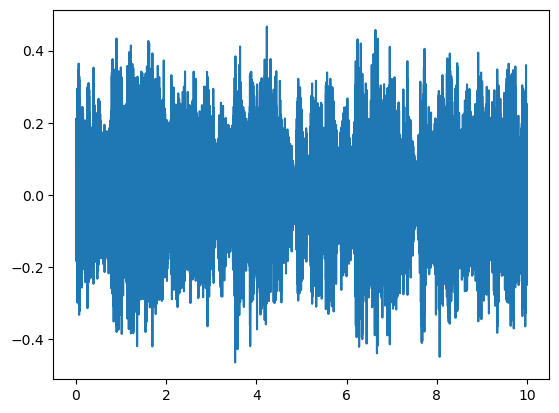

ValueError: 'log2' is not a valid value for scale; supported values are 'linear', 'log', 'symlog', 'asinh', 'logit', 'function', 'functionlog'

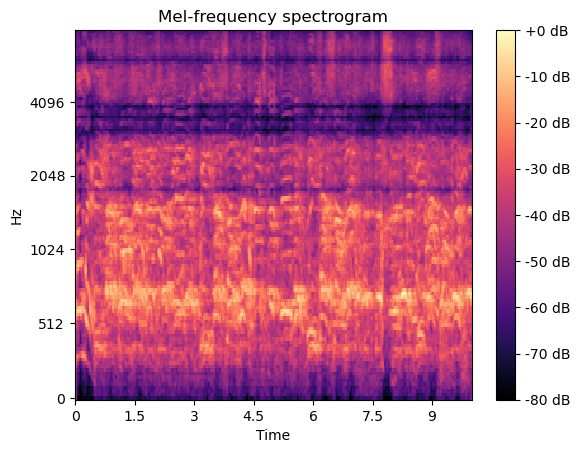

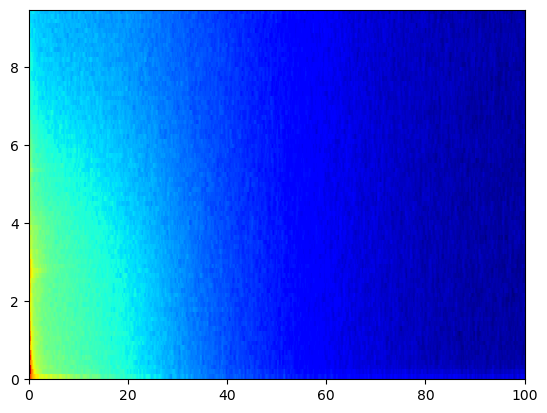

In [4]:
preproc(city_file_list[1], vis=True)